# Introduction



<center><img src="https://i.imgur.com/WoSvK1u.jpg" width="500px"></center>

In this kernel, I will do some basic EDA. I will visualize features in the dataset, and in the process, try to gain some insights about the patterns in the data. After that, I will show how to a CNN model in PyTorch to solve this problem. So let's get right into it :)

<font size=3 color='red'>Please upvote if you find it useful or interesting :) It motivates me to produce more quality content.</font>

### Install and import the necessary libraries

In [1]:
import os
import gc
import time
import math
import tqdm
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from tqdm import tqdm_notebook as tqdm
from kaggle.competitions import nflrush

env = nflrush.make_env()
iter_test = env.iter_test()

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

!pip install -qqq hiddenlayer
import hiddenlayer as hl

import IPython
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff


import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Declare the necessary constants

In [2]:
EPOCHS = 8
BATCH_SIZE = 128
DATA_PATH = '../input/nfl-big-data-bowl-2020/'

### Load the training data

In [3]:
train_df = pd.read_csv(DATA_PATH + 'train.csv')
train_df.head()

GameId          PlayId  Team      X      Y     S     A   Dis  \
0  2017090700  20170907000118  away  73.91  34.84  1.69  1.13  0.40   
1  2017090700  20170907000118  away  74.67  32.64  0.42  1.35  0.01   
2  2017090700  20170907000118  away  74.00  33.20  1.22  0.59  0.31   
3  2017090700  20170907000118  away  71.46  27.70  0.42  0.54  0.02   
4  2017090700  20170907000118  away  69.32  35.42  1.82  2.43  0.16   

   Orientation     Dir  ...  Week           Stadium        Location  \
0        81.99  177.18  ...     1  Gillette Stadium  Foxborough, MA   
1        27.61  198.70  ...     1  Gillette Stadium  Foxborough, MA   
2         3.01  202.73  ...     1  Gillette Stadium  Foxborough, MA   
3       359.77  105.64  ...     1  Gillette Stadium  Foxborough, MA   
4        12.63  164.31  ...     1  Gillette Stadium  Foxborough, MA   

   StadiumType        Turf     GameWeather Temperature Humidity  WindSpeed  \
0      Outdoor  Field Turf  Clear and warm        63.0     77.0          8   
1      Outdoor  Field Turf  Clear and warm        63.0     77.0          8   
2      Outdoor  Field Turf  Clear and warm        63.0     77.0          8   
3      Outdoor  Field Turf  Clear and warm        63.0     77.0          8   
4      Outdoor  Field Turf  Clear and warm        63.0     77.0          8   

   WindDirection  
0             SW  
1             SW  
2             SW  
3             SW  
4             SW  

[5 rows x 49 columns]

# EDA 📊

Now, I am going to use **seaborn** and **plotly** to visualize and analyze the data.

<center><img src="https://i.imgur.com/HrT6xFJ.png" width="300px"></center>

## X coordinate

These are the *x*-coordinates of the players on the field during the games.

### Distribution plot

In [4]:
fig = ff.create_distplot(hist_data=[train_df.sample(frac=0.025)["X"]], group_labels="X", colors=['rgb(26, 153, 0)'])
fig.update_layout(title="X coordinate", yaxis=dict(title="Probability Density"), xaxis=dict(title="X coordinate"))
fig.show()

In the distribution plot above, we can see that the *x*-coordinates of the players in the dataset has a somewhat bimodal distribution. There are two major peaks in the probability density, at around 35 and 85 yards. This is probably where most players are concentrated on average: in between the midway line and their end of the field. The two peaks probably represent the two teams playing the game.

## X coordinate vs. Yards

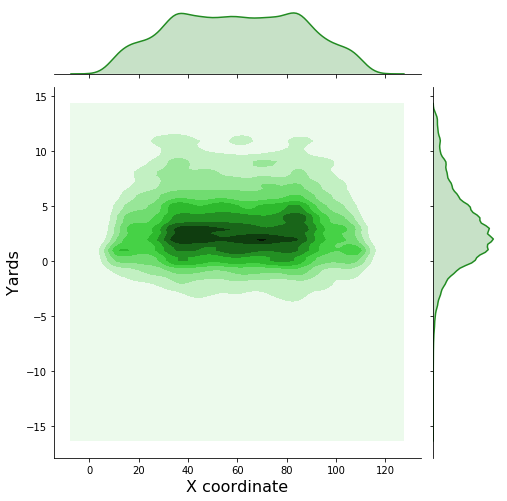

In [5]:
data = train_df.sample(frac=0.025)
quantile = data["Yards"].quantile(0.95)
data = data.loc[data["Yards"] < quantile]
plot = sns.jointplot(x=data["X"], y=data["Yards"], kind='kde', color='forestgreen', height=7)
plot.set_axis_labels('X coordinate', 'Yards', fontsize=16)
plt.show(plot)

In the KDE plot above, we can see that the *x*-coordinate does not have any clear correlation or relationship with the number of yards gained in the play. The density is concentrated at the center, at around **X = 50** and **Yards = 3**. The probability density decreases rapidly as one moves away from this central region, where most of the data is concentrated.

## Y coordinate

These are the *y*-coordinates of the players on the field during the games.

### Distribution plot

In [6]:
fig = ff.create_distplot(hist_data=[train_df.sample(frac=0.025)["Y"]], group_labels="Y", colors=['rgb(179, 0, 30)'])
fig.update_layout(title="Y coordinate", yaxis=dict(title="Probability Density"), xaxis=dict(title="Y coordinate"))
fig.show()

In the distribution plot above, we can see that the *y*-coordinates of the players in the dataset has a somewhat normal, unimodal distribution. There ais one major peaks in the probability density, at around **Y = 25** yards, which is near the center of the pitch. The two small peaks at the extreme ends of the distribution probably represent the players on the extreme left and right "sides" or "flanks" of the field.

## Y coordinate vs. Yards

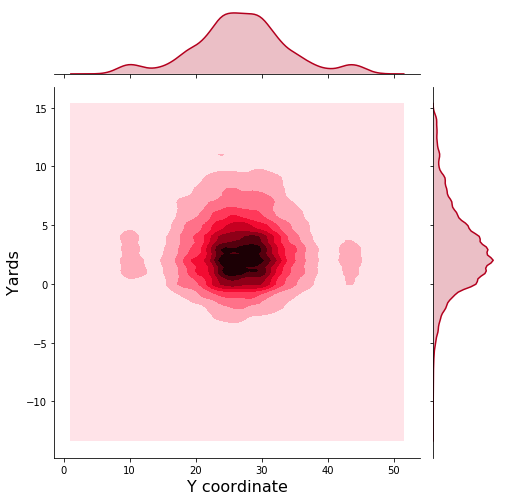

In [7]:
data = train_df.sample(frac=0.025)
quantile = data["Yards"].quantile(0.95)
data = data.loc[data["Yards"] < quantile]
plot = sns.jointplot(x=data["Y"], y=data["Yards"], kind='kde', color=(179/255, 0, 30/255), height=7)
plot.set_axis_labels('Y coordinate', 'Yards', fontsize=16)
plt.show(plot)

In the KDE plot above, we can see that the *y*-coordinate does not have any clear correlation or relationship with the number of yards gained in the play. The density is concentrated at the center, at around **Y = 25** and **Yards = 3**. The probability density decreases rapidly as one moves away from this central region, where most of the data is concentrated.

## X coordinate vs. Y coordinate

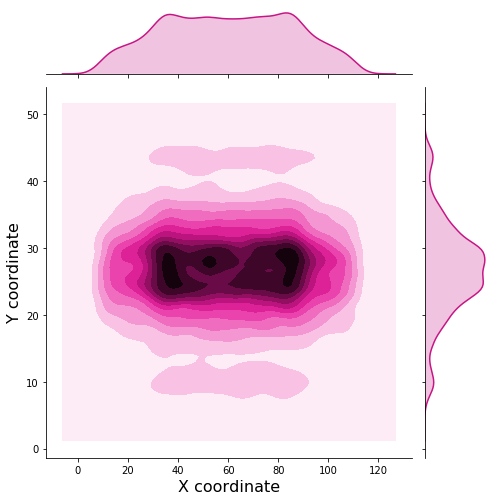

In [8]:
data = train_df.sample(frac=0.025)
plot = sns.jointplot(x=data["X"], y=data["Y"], kind='kde', color='mediumvioletred', height=7)
plot.set_axis_labels('X coordinate', 'Y coordinate', fontsize=16)
plt.show(plot)

In the plot above, we can see that most of the *xy*-coordinate data is concentrated around a flat rectangular region in the dead center of the field. The probability density decreases as we move away from this central rectangle. The rectange extends from **X = 35 to 85** and **Y = 20 to 30**.

## X coordinate vs. Y coordinate for different offense formations

Now, I will look at how the *xy*-coordinate distribution of players is different for different offense formations.

In [9]:
data = train_df

In [10]:
empty_data = data.query('OffenseFormation == "EMPTY"')
iform_data = data.query('OffenseFormation == "I_FORM"')
jumbo_data = data.query('OffenseFormation == "JUMBO"')
pistol_data = data.query('OffenseFormation == "PISTOL"')
shotgun_data = data.query('OffenseFormation == "SHOTGUN"')
singleback_data = data.query('OffenseFormation == "SINGLEBACK"')
wildcat_data = data.query('OffenseFormation == "WILDCAT"')

In [11]:
colors = ['red', 'orangered', 'orange', (179/255, 149/255, 0), 'forestgreen', 'blue', 'blueviolet', 'darkviolet']

### Empty formation

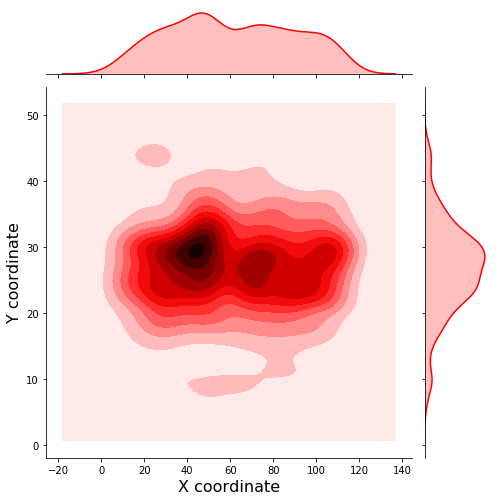

In [12]:
plot = sns.jointplot(x=empty_data["X"], y=empty_data["Y"], kind='kde', color=colors[0], height=7)
plot.set_axis_labels('X coordinate', 'Y coordinate', fontsize=16)
plt.show(plot)

In the plot above (for the "empty" formation), we can see that the *x*-coordinates are concentrated heavily around the **X = 40** mark. Maybe this suggests that attacks of this form occur mainly from the left side of the field, because this value of **X** is closer to the left end of the field than the right end. But, there is also comparatively less dense region of probability density at around **X = 80**, suggesting that attacks can also take place from the other side of the field, but this is less likely.

### "I" formation

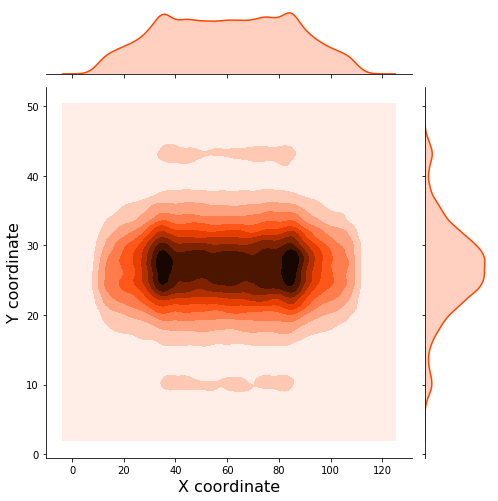

In [13]:
plot = sns.jointplot(x=iform_data["X"], y=iform_data["Y"], kind='kde', color=colors[1], height=7)
plot.set_axis_labels('X coordinate', 'Y coordinate', fontsize=16)
plt.show(plot)

In the plot above (for the "I" formation), we can see that most of the *xy*-coordinate data is concentrated around a flat rectangular region in the dead center of the field. The probability density decreases as we move away from this central rectangle. The rectange extends from **X = 10 to 110** and **Y = 15 to 35**. This suggests that most attacks of this type occur from the center of the field. But, there are also minor regions of density at the top and bottom extremes of the field, suggesting that such attacks can also take place from the left and right flanks of the field.

### Jumbo formation

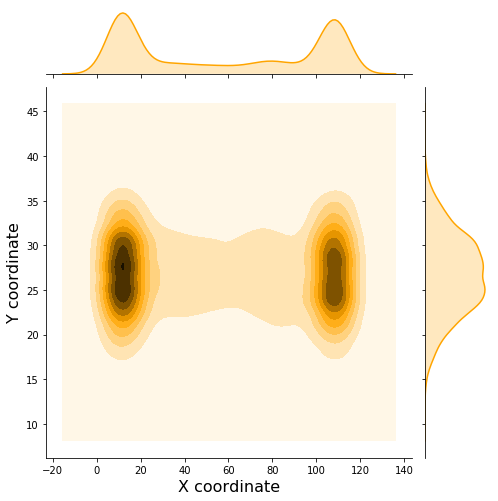

In [14]:
plot = sns.jointplot(x=jumbo_data["X"], y=jumbo_data["Y"], kind='kde', color=colors[2], height=7)
plot.set_axis_labels('X coordinate', 'Y coordinate', fontsize=16)
plt.show(plot)

In the plot above (for the "jumbo" formation), we can see that most of the *xy*-coordinate data is heavily concentrated at two regions on the field, at around **X = 10** and **X = 110**. The density in between these two regions is comparatively very low. This suggests that such attacks generally take place at the left and right extremes of the field, and not at the center.

### Pistol formation

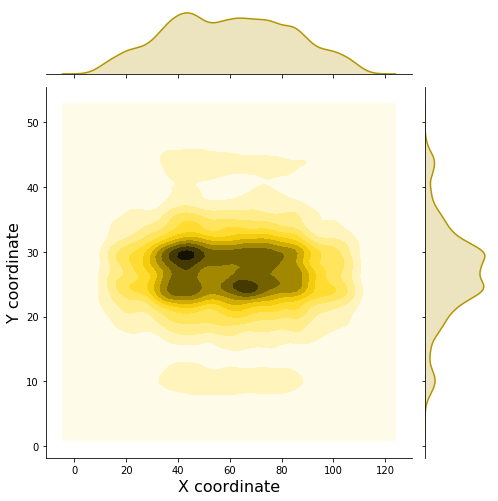

In [15]:
plot = sns.jointplot(x=pistol_data["X"], y=pistol_data["Y"], kind='kde', color=colors[3], height=7)
plot.set_axis_labels('X coordinate', 'Y coordinate', fontsize=16)
plt.show(plot)

In the plot above (for the "pistol" formation), we can see that most of the *xy*-coordinate data is concentrated around a flat rectangular region in the dead center of the field. The probability density decreases as we move away from this central rectangle. The rectange extends from **X = 10 to 110** and **Y = 15 to 35**. This suggests that most attacks of this type occur from the center of the field. But, there are also minor regions of density at the top and bottom extremes of the field, suggesting that such attacks can also take place from the left and right flanks of the field.

### Shotgun formation

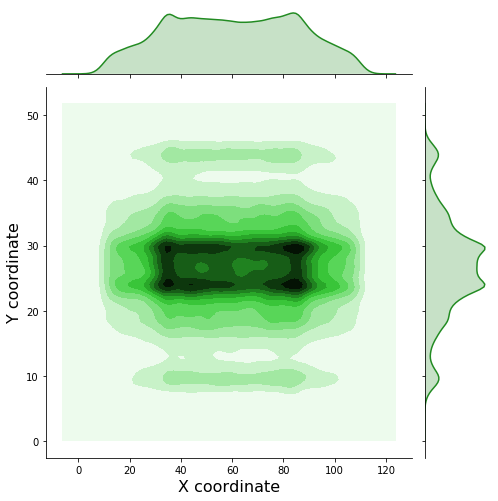

In [16]:
plot = sns.jointplot(x=shotgun_data["X"], y=shotgun_data["Y"], kind='kde', color=colors[4], height=7)
plot.set_axis_labels('X coordinate', 'Y coordinate', fontsize=16)
plt.show(plot)

Once again, in the plot above (for the "shotgun" formation), we can see that most of the *xy*-coordinate data is concentrated around a flat rectangular region in the dead center of the field. The probability density decreases as we move away from this central rectangle. The rectange extends from **X = 10 to 110** and **Y = 15 to 35**. This suggests that most attacks of this type occur from the center of the field. But, there are also minor regions of density at the top and bottom extremes of the field, suggesting that such attacks can also take place from the left and right flanks of the field.

### Singleback formation

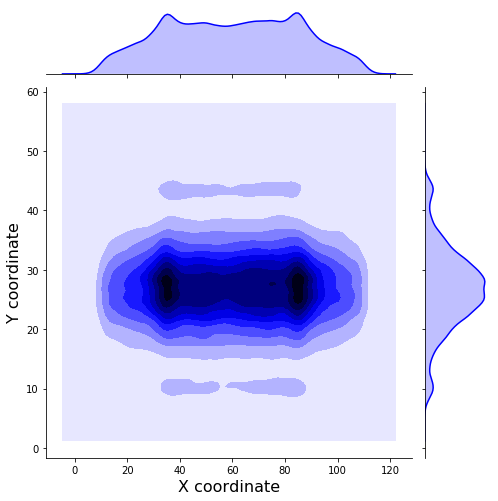

In [17]:
plot = sns.jointplot(x=singleback_data["X"], y=singleback_data["Y"], kind='kde', color=colors[5], height=7)
plot.set_axis_labels('X coordinate', 'Y coordinate', fontsize=16)
plt.show(plot)

We can see a similar pattern to the "pistol" formation here. In the plot above (for the "singleback" formation), we can see that most of the *xy*-coordinate data is concentrated around a flat rectangular region in the dead center of the field. The probability density decreases as we move away from this central rectangle. The rectange extends from **X = 10 to 110** and **Y = 15 to 35**. This suggests that most attacks of this type occur from the center of the field. But, there are also minor regions of density at the top and bottom extremes of the field, suggesting that such attacks can also take place from the left and right flanks of the field.

### Wilcat formation

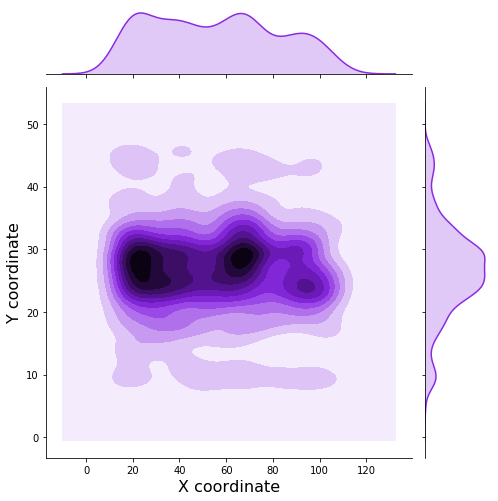

In [18]:
plot = sns.jointplot(x=wildcat_data["X"], y=wildcat_data["Y"], kind='kde', color=colors[6], height=7)
plot.set_axis_labels('X coordinate', 'Y coordinate', fontsize=16)
plt.show(plot)

In the plot above (for the "wildcat" formation), we can see that the *x*-coordinates are concentrated heavily around the **X = 20** and **X = 70** marks. Maybe this suggests that attacks of this form occur from both sides of the field. But, every few attacks of this form at values of **X > 110**.

## Dir

**Dir** is the angle of the player's motion during the play

### Distribution plot

In [19]:
fig = ff.create_distplot(hist_data=[train_df.sample(frac=0.025).query('Dir == Dir')["Dir"]], group_labels=["Dir"], colors=['rgb(255, 102, 25)'])
fig.update_layout(title="Dir", yaxis=dict(title="Probability Density"), xaxis=dict(title="Dir"))
fig.show()

From the above plot, we can see that the distribution of **Dir** is roughly trimodal (three peaks). One peak occurs approximately at the center at around **Dir = 190**, and the other two peaks occur at the extreme ends of the distribution, at **Dir = 0** and **Dir = 350**. This probably represents two types of motion in players: almost straight motion (0 or 350 degrees) and diagonal motion (190 degrees).

## Dir vs. Yards

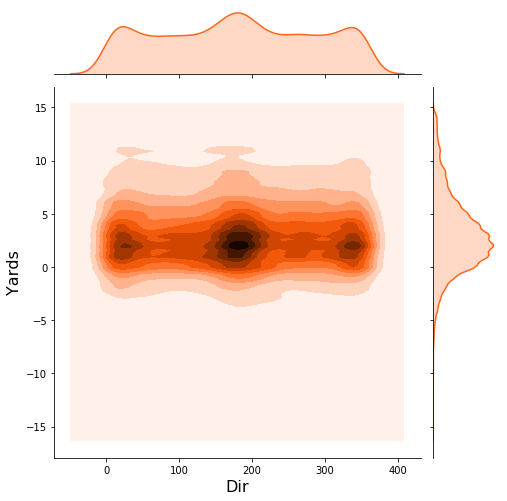

In [20]:
data = train_df.sample(frac=0.025)
quantile = data["Yards"].quantile(0.95)
data = data.loc[data["Yards"] < quantile]
plot = sns.jointplot(x=data["Dir"], y=data["Yards"], kind='kde', color=(255/255, 102/255, 25/255), height=7)
plot.set_axis_labels('Dir', 'Yards', fontsize=16)
plt.show(plot)

In the KDE plot above, we can see that the **Dir** value does not have any clear correlation or relationship with the number of yards gained in the play. The density is concentrated at three symmetric  areas around the center, at **Dir = 0, 190 and 350**. The probability density decreases rapidly as one moves away from these three region, where most of the data is concentrated.

## Acceleration

**A** is the acceleration of the player in yards per second per second.

### Distribution plot

In [21]:
fig = ff.create_distplot(hist_data=[train_df.sample(frac=0.025)["A"]], group_labels="A", colors=['rgb(0, 0, 230)'])
fig.update_layout(title="A", yaxis=dict(title="Probability Density"), xaxis=dict(title="A"))
fig.show()

In the plot above, we can see that the distribution of **A** is asymmetrical, unimodal, and heavily skewed to the right. The probability density of the acceleration peaks at around **A = 1** yard per second per second. 

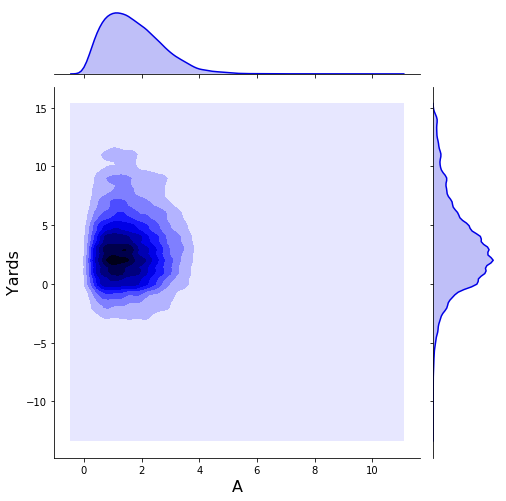

In [22]:
data = train_df.sample(frac=0.025)
quantile = data["Yards"].quantile(0.95)
data = data.loc[data["Yards"] < quantile]
plot = sns.jointplot(x=data["A"], y=data["Yards"], kind='kde', color=(0, 0, 230/255), height=7)
plot.set_axis_labels('A', 'Yards', fontsize=16)
plt.show(plot)

In the KDE plot above, we can see that the acceleration does not have any clear correlation or relationship with the number of yards gained in the play. The density is concentrated at the left edge, at around **A = 1** and **Yards = 3**. The probability density decreases as one moves away from this central region, where most of the data is concentrated.

## Speed

**S** is the speed of the player in yards per second.

In [23]:
fig = ff.create_distplot(hist_data=[train_df.sample(frac=0.025)["S"]], group_labels="S", colors=['rgb(230, 0, 191)'])
fig.update_layout(title="S", yaxis=dict(title="Probability Density"), xaxis=dict(title="S"))
fig.show()

In the plot above, we can see that the distribution of **S** is asymmetrical, unimodal, and heavily skewed to the right. The probability density of the speed peaks at around **S = 2** yard per second. 

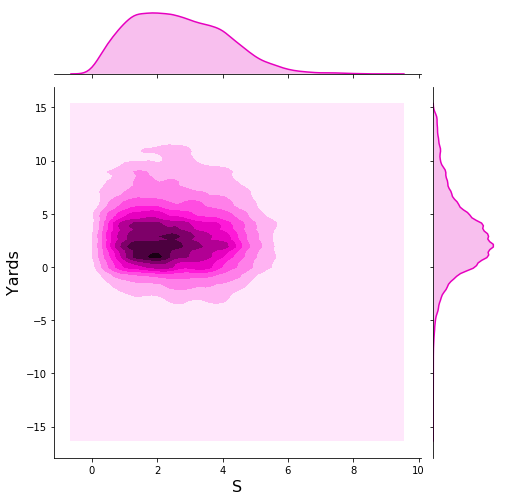

In [24]:
data = train_df.sample(frac=0.025)
quantile = data["Yards"].quantile(0.95)
data = data.loc[data["Yards"] < quantile]
plot = sns.jointplot(x=data["S"], y=data["Yards"], kind='kde', color=(230/255, 0, 191/255), height=7)
plot.set_axis_labels('S', 'Yards', fontsize=16)
plt.show(plot)

In the KDE plot above, we can see that the speed does not have any clear correlation or relationship with the number of yards gained in the play. The density is concentrated at the left edge, at around **S = 2** and **Yards = 3**. The probability density decreases as one moves away from this central region, where most of the data is concentrated.

## Humidity

Humidity is the percentage (from 0 to 100) of water vapour present in the air during the game.

### Dsitribution plot

In [25]:
data = train_df.sample(frac=0.025)["Humidity"]
fig = ff.create_distplot(hist_data=[data.fillna(data.mean())], group_labels=["Humidity"], colors=['rgb(0, 102, 102)'])
fig.update_layout(title="Humidity", yaxis=dict(title="Probability Density"), xaxis=dict(title="Humidity"))
fig.show()

In the plot above, we can see that the distribution of humidity in the dataset has a slight leftward skew and is bimodal in nature. The distribution has two peaks at around **Humidity = 0 and 70**. The first peak, at **Humidity = 0** is very sudden and goes against the gentle leftward skew of the data.

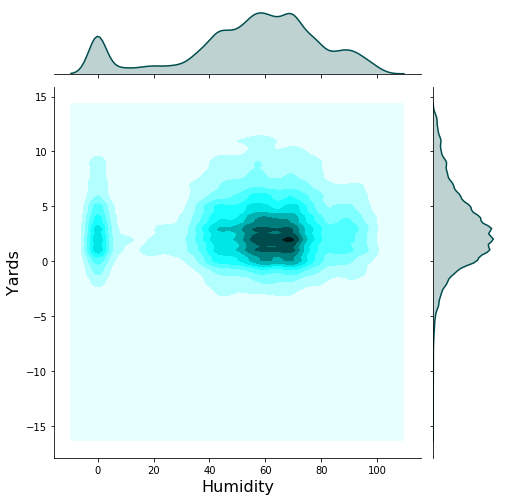

In [26]:
data = train_df.sample(frac=0.025)
quantile = data["Yards"].quantile(0.95)
data = data.loc[data["Yards"] < quantile]
plot = sns.jointplot(x=data["Humidity"], y=data["Yards"], kind='kde', color=(0/255, 77/255, 77/255), height=7)
plot.set_axis_labels('Humidity', 'Yards', fontsize=16)
plt.show(plot)

In the KDE plot above, we can see that the humidity does not have any clear correlation or relationship with the number of yards gained in the play. The density is concentrated at the right edge, at around **Humidity = 70** and **Yards = 3**. There is another high density region at **Humidity = 0**. The probability density decreases as one moves away from these regions, where most of the data is concentrated.

## Temperature

**Temperature** is the temperature (in degrees Fahrenheit) during the game.

In [27]:
data = train_df.sample(frac=0.025)["Temperature"]
fig = ff.create_distplot(hist_data=[data.fillna(data.mean())], group_labels=["Temperature"], colors=['rgb(51, 34, 0)'])
fig.update_layout(title="Temperature", yaxis=dict(title="Probability Density"), xaxis=dict(title="Temperature"))

In the plot above, we can see that the distribution of humidity in the dataset has a slight leftward skew and is roughly unimodal in nature. The distribution has one peak at around **Temperature = 60** degrees Fahrenheit.

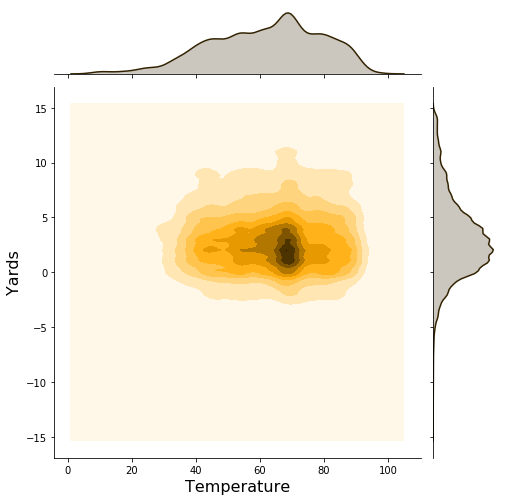

In [28]:
data = train_df.sample(frac=0.025)
quantile = data["Yards"].quantile(0.95)
data = data.loc[data["Yards"] < quantile]
plot = sns.jointplot(x=data["Temperature"], y=data["Yards"], kind='kde', color=(51/255, 34/255, 0), height=7)
plot.set_axis_labels('Temperature', 'Yards', fontsize=16)
plt.show(plot)

In the KDE plot above, we can see that the humidity does not have any clear correlation or relationship with the number of yards gained in the play. The density is concentrated towards the right side, at around **Temperature = 60** and **Yards = 3**. The probability density decreases as one moves away from this region, where most of the data is concentrated.

## Team vs. Yards

### Distribution plot

In [29]:
data = train_df.sample(frac=0.025)
quantile = data["Yards"].quantile(0.95)
data = data.loc[data["Yards"] < quantile]
away_data = data.query('Team == "away"')["Yards"]
home_data = data.query('Team == "home"')["Yards"]

fig = ff.create_distplot(hist_data=[away_data, home_data],
                         group_labels=["Away", "Home"],
                         show_hist=False)

fig.update_layout(title="Team vs. Yards", yaxis=dict(title="Probability Density"), xaxis=dict(title="Yards"))
fig.show()

In the plot above, we can see that the distribution of yards gained is almost identical for home teams and away teams. Therefore, whether a player is from the home team or the away team does not affect the yards gained during a play.

### Box plot

In [30]:
fig = go.Figure()
data = [away_data, home_data]
tags = ["Away", "Home"]

for index, category in enumerate(data):
    fig.add_trace(go.Box(y=category, name=tags[index]))

fig.update_layout(title="Team vs. Yards", yaxis=dict(title="Yards"), xaxis=dict(title="Team"))
fig.show()

In the above plot, we can once again see that the distribution of yards gained is almost identical for home and away teams.

### Violin plot

In [31]:
fig = go.Figure()
data = [away_data, home_data]
tags = ["Away", "Home"]

for index, category in enumerate(data):
    fig.add_trace(go.Violin(y=category, name=tags[index]))

fig.update_layout(title="Team vs. Yards", yaxis=dict(title="Yards"), xaxis=dict(title="Team"))
fig.show()

The above plot, once gain, reinforces the fact that the distributions are very similar.

## WindDirection vs. Yards

### Distribution plot

In [32]:
data = train_df.sample(frac=0.025)
quantile = data["Yards"].quantile(0.95)
data = data.loc[data["Yards"] < quantile]
north_data = data.query('WindDirection == "N"')["Yards"]
east_data = data.query('WindDirection == "E"')["Yards"]
west_data = data.query('WindDirection == "W"')["Yards"]
south_data = data.query('WindDirection == "S"')["Yards"]

fig = ff.create_distplot(hist_data=[north_data, east_data, west_data, south_data],
                         group_labels=["North", "East", "West", "South"],
                         show_hist=False)

fig.update_layout(title="WindDirection vs. Yards", yaxis=dict(title="Probability Density"), xaxis=dict(title="Yards"))
fig.show()

All the distributions above are unimodal and seem to have a slight rightward skew. The distributions are different from each other, but the difference in not very sizeable. The distribution for **East** wind direction has the highest mean yards gained, whereas the **West** wind direction has the lowest mean yards gained.

### Box plot

In [33]:
fig = go.Figure()
data = [north_data, east_data, west_data, south_data]
tags = ["North", "East", "West", "South"]

for index, category in enumerate(data):
    fig.add_trace(go.Box(y=category, name=tags[index]))
    
fig.update_layout(title="WindDirection vs. Yards", yaxis=dict(title="Yards"), xaxis=dict(title="WindDirection"))
fig.show()

In the above plot, we can once again see that the distribution of yards gained are somewhat similar for different wind directions. But, the distribution for **East** wind direction has the highest mean yards gained, whereas the **West** wind direction has the lowest mean yards gained. 

### Violin plot

In [34]:
fig = go.Figure()
data = [north_data, east_data, west_data, south_data]
tags = ["North", "East", "West", "South"]

for index, category in enumerate(data):
    fig.add_trace(go.Violin(y=category, name=tags[index]))

fig.update_layout(title="WindDirection vs. Yards", yaxis=dict(title="Yards"), xaxis=dict(title="WindDirection"))
fig.show()

The above plot, once gain, reinforces the fact that the distributions are very similar, but the **West** distribution has the highest mean and the **East** distribution has the lowest mean.

## Offense formation vs. Yards

### Distribution plot

In [35]:
data = train_df.sample(frac=0.025)
quantile = data["Yards"].quantile(0.95)
data = data.loc[data["Yards"] < quantile]
empty_data = data.query('OffenseFormation == "EMPTY"')["Yards"]
iform_data = data.query('OffenseFormation == "I_FORM"')["Yards"]
jumbo_data = data.query('OffenseFormation == "JUMBO"')["Yards"]
pistol_data = data.query('OffenseFormation == "PISTOL"')["Yards"]
shotgun_data = data.query('OffenseFormation == "SHOTGUN"')["Yards"]
singleback_data = data.query('OffenseFormation == "SINGLEBACK"')["Yards"]
wildcat_data = data.query('OffenseFormation == "WILDCAT"')["Yards"]

fig = ff.create_distplot(hist_data=[empty_data, iform_data, jumbo_data,
                                    pistol_data, shotgun_data, singleback_data, wildcat_data],
                         group_labels=["Empty", "I-Form", "Jumbo", "Pistol",
                                       "Shotgun", "Singleback", "Wildcat"],
                         show_hist=False)

fig.update_layout(title="OffenseFormation vs. Yards", yaxis=dict(title="Probability Density"), xaxis=dict(title="Yards"))
fig.show()

In the above plot, we can see that most of the distributions are very similar except the **Jumbo** and **Empty** distributions. Although all the distributions are unimodal and roughly normal, the distribution for **Jumbo** has a significantly lower mean than the other distributions, and the distributions for **Empty**, on the other hand, has a significantly higher mean than the other distributions. Therefore, **Empty** offense formations generally tend to have higher yards gained than average. And, **Jumbo** offense formations generally tend to have lower yards gained than average.

### Box plot

In [36]:
fig = go.Figure()
data = [empty_data, iform_data, jumbo_data, pistol_data, shotgun_data, singleback_data, wildcat_data]
tags = ["Empty", "I-Form", "Jumbo", "Pistol", "Shotgun", "Singleback", "Wildcat"]

for index, category in enumerate(data):
    fig.add_trace(go.Box(y=category, name=tags[index]))

fig.update_layout(title="OffenseFormation vs. Yards", yaxis=dict(title="Yards"), xaxis=dict(title="OffenseFormation"))
fig.show()

The plot above also shows that **Empty** formations generally result in higher-than-average yards gained, and **Jumbo** formations generally result in lower-than-average yards gained. All the other formations are almost exactly identical to each other in terms of yards gained.

### Violin plot

In [37]:
fig = go.Figure()
data = [empty_data, iform_data, jumbo_data, pistol_data, shotgun_data, singleback_data, wildcat_data]
tags = ["Empty", "I-Form", "Jumbo", "Pistol", "Shotgun", "Singleback", "Wildcat"]

for index, category in enumerate(data):
    fig.add_trace(go.Violin(y=category, name=tags[index]))

fig.update_layout(title="OffenseFormation vs. Yards", yaxis=dict(title="Yards"), xaxis=dict(title="OffenseFormation"))
fig.show()

The above plot, once gain, reinforces the fact that **Empty** formations generally result in higher-than-average yards gained, and **Jumbo** formations generally result in lower-than-average yards gained.

## HomeTeamAbbr vs. Yards

### Distribution plot

In [38]:
data = train_df.sample(frac=0.025)
quantile = data["Yards"].quantile(0.95)
data = data.loc[data["Yards"] < quantile]
hist_data = [data.loc[data["HomeTeamAbbr"] == home_team_abbr]["Yards"] for home_team_abbr in set(data['HomeTeamAbbr'])]

fig = ff.create_distplot(hist_data=hist_data, group_labels=list(set(data['HomeTeamAbbr'])), show_hist=False)
fig.update_layout(title="HomeTeamAbbr vs. Yards", yaxis=dict(title="Probability Density"), xaxis=dict(title="Yards"))
fig.show()

From the above plot, we can see that almost all the home teams have very similar distributions of yards gained.

In [39]:
hist_data = [ele for ele in reversed(hist_data)] 
tags = [ele for ele in reversed(list(set(data['HomeTeamAbbr'])))]

### Box plot

In [40]:
fig = go.Figure()

for index, category in enumerate(hist_data):
    fig.add_trace(go.Box(y=category, name=tags[index]))

fig.update_layout(title="HomeTeamAbbr vs. Yards", yaxis=dict(title="Yards"), xaxis=dict(title="HomeTeamAbbr"))
fig.show()

In the above plot, we can see that most distributions are similar. But, the few teams that have the highest average yards gained are the **Wahington Redskins, Oakland Raiders, and Green Bay Packers**. On the other hand, the teams that have the lowest average yards gained are the **Chicago Bears and New York Jets**. 

### Violin plot

In [41]:
fig = go.Figure()

for index, category in enumerate(hist_data):
    fig.add_trace(go.Violin(y=category, name=tags[index]))

fig.update_layout(title="HomeTeamAbbr vs. Yards", yaxis=dict(title="Yards"), xaxis=dict(title="HomeTeamAbbr"))
fig.show()

We can the same pattern in this plot.

* **Highest Yards Gained**: Wahington Redskins, Oakland Raiders, and Green Bay Packers
* **Lowest Yards Gained**: Chicago Bears and New York Jets

## VisitorTeamAbbr vs. Yards

### Distribution plot

In [42]:
data = train_df.sample(frac=0.025)
quantile = data["Yards"].quantile(0.95)
data = data.loc[data["Yards"] < quantile]
hist_data = [data.loc[data["VisitorTeamAbbr"] == visitor_team_abbr]["Yards"] for visitor_team_abbr in set(data['VisitorTeamAbbr'])]

fig = ff.create_distplot(hist_data=hist_data, group_labels=list(set(data['VisitorTeamAbbr'])), show_hist=False)
fig.update_layout(title="VisitorTeamAbbr vs. Yards", yaxis=dict(title="Probability Density"), xaxis=dict(title="Yards"))
fig.show()

From the above plot, we can see that almost all the visitor teams have very similar distributions of yards gained.

In [43]:
hist_data = [ele for ele in reversed(hist_data)]
tags = [ele for ele in reversed(list(set(data['VisitorTeamAbbr'])))]

### Box plot

In [44]:
fig = go.Figure()

for index, category in enumerate(hist_data):
    fig.add_trace(go.Box(y=category, name=tags[index]))

fig.update_layout(title="VisitorTeamAbbr vs. Yards", yaxis=dict(title="Yards"), xaxis=dict(title="VisitorTeamAbbr"))
fig.show()

In the above plot, we can see that most distributions are similar. But, the few teams that have the highest average yards gained are the **Oakland Raiders, New England Patriots, and Minnesota Vikings**. On the other hand, the teams that have the lowest average yards gained are the **Jacksonville Jaguars and Carolina Panthers**. 

In [45]:
fig = go.Figure()

for index, category in enumerate(hist_data):
    fig.add_trace(go.Violin(y=category, name=tags[index]))

fig.update_layout(title="VisitorTeamAbbr vs. Yards", yaxis=dict(title="Yards"), xaxis=dict(title="VisitorTeamAbbr"))
fig.show()

We can the same pattern in this plot.

* **Highest Yards Gained**: Oakland Raiders, New England Patriots, and Minnesota Vikings
* **Lowest Yards Gained**: Jacksonville Jaguars and Carolina Panthers

# PyTorch Model 🔥

<center><img src="https://i.imgur.com/GOs1cLy.jpg" width="500px"></center>

Now, I am going to show how to build a CNN model to solve this problem using PyTorch.

### Get categorical value sets

In [46]:
cat_cols = ['Team', 'FieldPosition', 'OffenseFormation']
value_dicts = []

for feature in cat_cols:
    values = set(train_df[feature])
    value_dicts.append(dict(zip(values, np.arange(len(values)))))

### Define helper functions to generate categorical features

In [47]:
def indices(data, feat_index):
    value_dict = value_dicts[feat_index]
    return data[cat_cols[feat_index]].apply(lambda x: value_dict[x])

def one_hot(indices, feat_index):
    return to_categorical(indices, num_classes=len(value_dicts[feat_index]))

In [48]:
def get_categorical_features(sample, data):
    index_values = [indices(sample, index) for index in range(len(value_dicts))]
    features = tuple([one_hot(value, index) for index, value in enumerate(index_values)])
    features = np.concatenate(features, axis=1)
    return features

### Define helper functions to generate numerical features

In [49]:
num_cols = ['X', 'S', 'A', 'Dis', 'Orientation', 'Dir', 'YardLine',
            'Quarter', 'Down', 'Distance', 'HomeScoreBeforePlay',
            'VisitorScoreBeforePlay', 'DefendersInTheBox', 'PlayerWeight',
            'Week', 'Temperature', 'Humidity']

def get_numerical_features(sample):
    return sample[num_cols].values

### Define a PyTorch Dataset for the problem

**What is happening here?**

Here are the steps:

* Group all the data by PlayId
* Get the 2D data from each PlayId
* Generate a 2D array with the numerical and categorical features for each PlayId
* Get the labels for each play
* Return the features and labels for each play

In [50]:
class NFLCompetitionDataset(Dataset):
    
    def __init__(self, data, stage):
        self.dataframe = data
        self.stage = stage
        self.play_ids = list(set(data['PlayId']))
            
    def __len__(self):
        return len(self.play_ids)
        
    def __getitem__(self, index):
        data_locations = self.dataframe['PlayId'] == self.play_ids[index]
        data_sample = self.dataframe.loc[data_locations]
        labels = np.array(data_sample['Yards'])
        labels = np.pad(labels, (0, 25 - len(labels)),
                        mode='constant',
                        constant_values=0)

        numerical_features = get_numerical_features(data_sample)
        features = numerical_features

        padding_length = 25 - features.shape[0]
        inds = np.where(np.isnan(features))
        features[inds] = np.take(np.nanmean(features, axis=0), inds[1])
        inds = np.where(np.isnan(features))
        features[inds] = 0
    
        if padding_length != 0:
            padding_values = np.vstack([np.mean(features, axis=0).reshape(1, -1)]*padding_length)
        
        features = np.concatenate((features, padding_values), axis=0)
        return features, labels

### Generate training and validation sets (80% split)

In [51]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
split = np.int32(0.8 * len(train_df))

train_set = NFLCompetitionDataset(data=train_df.iloc[:split], stage='train')
val_set = NFLCompetitionDataset(data=train_df.iloc[split:], stage='val')

## 1D CNN Model

### Define the 1D CNN architecture

In [52]:
class CNN1DNetwork(nn.Module):
    
    def __init__(self):
        super(CNN1DNetwork, self).__init__()
        
        self.conv1d_1 = nn.Conv1d(in_channels=17, out_channels=100, kernel_size=2)
        self.conv1d_2 = nn.Conv1d(in_channels=17, out_channels=100, kernel_size=3)
        self.conv1d_3 = nn.Conv1d(in_channels=17, out_channels=100, kernel_size=4)
        self.conv1d_4 = nn.Conv1d(in_channels=17, out_channels=100, kernel_size=5)
        
        self.dense_1 = nn.Linear(in_features=400, out_features=64)
        self.dense_2 = nn.Linear(in_features=64, out_features=25)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.float().permute(0, 2, 1)
        conv_1 = self.conv1d_1(x)
        conv_2 = self.conv1d_2(x)
        conv_3 = self.conv1d_3(x)
        conv_4 = self.conv1d_4(x)
    
        max_pool_1, _ = torch.max(conv_1, 2)
        max_pool_2, _ = torch.max(conv_2, 2)
        max_pool_3, _ = torch.max(conv_3, 2)
        max_pool_4, _ = torch.max(conv_4, 2)
        
        features = torch.cat((max_pool_1, max_pool_2, max_pool_3, max_pool_4), 1)
        conc = self.dense_1(features)
        conc = self.relu(conc)
        out = self.dense_2(conc)
        return out

### Visualize neural network architecture

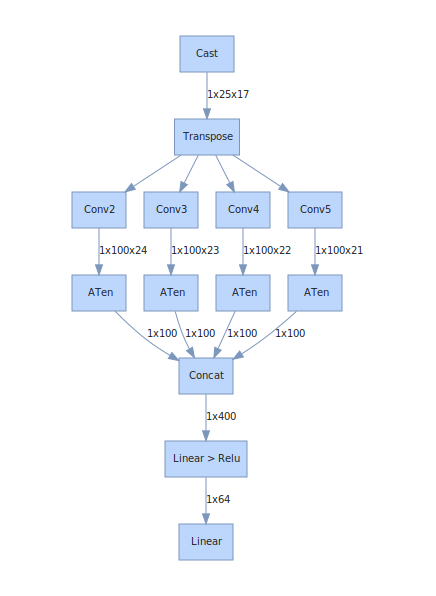

In [53]:
hl_graph = hl.build_graph(CNN1DNetwork(), torch.zeros([1, 25, 17]))
hl_graph.theme = hl.graph.THEMES["blue"].copy()
hl_graph

### Initialize data loaders

In [54]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

### Calculate the data mean and standard deviation for normalization

In [55]:
mean = 0.
std = 0.
nb_samples = 0.

for data, _ in tqdm(train_loader):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean((0, 1))
    std += data.std((0, 1))
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

### Train the model (with MSE loss)

In [56]:
start = time.time()
network = CNN1DNetwork()
optimizer = Adam(network.parameters(), lr=0.01)
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print("EPOCH " + str(epoch + 1))
    print("")
    
    for (train_batch, val_batch) in zip(train_loader, val_loader):
        train_X, train_y = train_batch
        val_X, val_y = val_batch
        
        train_len = train_X.shape[0]
        val_len = val_X.shape[0]
        
        train_mean = torch.cat(train_len*[torch.cat(25*[mean.view(1, 17)], 0).view(1, 25, 17)], 0)*train_len
        train_std = torch.cat(train_len*[torch.cat(25*[std.view(1, 17)], 0).view(1, 25, 17)], 0)*train_len
        val_mean = torch.cat(val_len*[torch.cat(25*[mean.view(1, 17)], 0).view(1, 25, 17)], 0)*val_len
        val_std = torch.cat(val_len*[torch.cat(25*[std.view(1, 17)], 0).view(1, 25, 17)], 0)*val_len

        train_X = (train_X - train_mean)/train_std
        val_X = (val_X - val_mean)/val_std

        train_y = torch.tensor(train_y, dtype=torch.float)
        val_y = torch.tensor(val_y, dtype=torch.float)
        
        train_preds = network.forward(train_X)
        train_loss = nn.MSELoss()(train_preds, train_y)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        val_preds = network.forward(val_X)
        val_loss = nn.MSELoss()(val_preds, val_y)
    
    end = time.time()
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    print("Train loss: " + str(np.round(train_loss.item(), 3)) + "   " +\
          "Val loss: " + str(np.round(val_loss.item(), 3)) + "   " +\
          "Total time: " + str(np.round(end - start, 1)) + " s")
    print("")

EPOCH 1

Train loss: 13.917   Val loss: 19.066   Total time: 233.8 s

EPOCH 2

Train loss: 15.106   Val loss: 19.251   Total time: 465.2 s

EPOCH 3

Train loss: 34.966   Val loss: 7.909   Total time: 701.9 s

EPOCH 4

Train loss: 15.093   Val loss: 23.109   Total time: 939.9 s

EPOCH 5

Train loss: 33.24   Val loss: 24.488   Total time: 1173.5 s

EPOCH 6

Train loss: 37.908   Val loss: 148.334   Total time: 1404.8 s

EPOCH 7

Train loss: 16.719   Val loss: 17.811   Total time: 1638.0 s

EPOCH 8

Train loss: 17.437   Val loss: 15.347   Total time: 1870.9 s



### Visualize training and validation losses

### Line plot

In [57]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5, 6, 7, 8], y=train_losses,
    name='train', mode='lines+markers',
    marker_color='crimson'
))

fig.add_trace(go.Scatter(
    x=[1, 2, 3, 4, 5, 6, 7, 8], y=val_losses,
    name='val', mode='lines+markers',
    marker_color=' indigo'
))

fig.update_traces(mode='lines+markers', marker_line_width=2, marker_size=10)
fig.update_layout(title='Loss over the epochs', yaxis_zeroline=False, xaxis_zeroline=False)
fig.update_layout(title="Loss over the epochs", yaxis=dict(title="MSE Loss"), xaxis=dict(title="Epochs"))
fig.show()

### Bar plot

In [58]:
labels=['Epoch 1', 'Epoch 2', 'Epoch 3', 'Epoch 4',
        'Epoch 5', 'Epoch 6', 'Epoch 7', 'Epoch 8']

fig = go.Figure(data=[
    go.Bar(name='train', x=labels, y=train_losses, marker={'color' : 'crimson'}),
    go.Bar(name='val', x=labels, y=val_losses, marker={'color' : 'indigo'})
])

fig.update_layout(title="Loss over the epochs", yaxis=dict(title="MSE Loss"))
fig.update_layout(barmode='group')
fig.show()

### Generate predictions

In [59]:
test_mean = torch.cat(25*[mean.view(1, 17)], 0).view(1, 25, 17)
test_std = torch.cat(25*[std.view(1, 17)], 0).view(1, 25, 17)

In [60]:
def generate_prediction(data_sample):
    numerical_features = get_numerical_features(data_sample)
    features = numerical_features

    padding_length = 25 - features.shape[0]
    length = features.shape[0]
    inds = np.where(np.isnan(features))
    features[inds] = np.take(np.nanmean(features, axis=0), inds[1])
    inds = np.where(np.isnan(features))
    features[inds] = 0
    
    if padding_length != 0:
        padding_values = np.vstack([np.mean(features, axis=0).reshape(1, -1)]*padding_length)
        
    features = np.concatenate((features, padding_values), axis=0)
    features = (features - test_mean.numpy())/test_std.numpy()
    prediction = network.forward(torch.FloatTensor(features).view(1, 25, 17)).detach().numpy().reshape((25, 1))
    pred = np.zeros((length, 199))

    for index, row in enumerate(prediction):
        if np.int32(np.round(row[0])) < 100:
            pred[index][np.int32(np.round(row[0])) + 99:] = 1
        else:
            pred[index][-1] = 1

        if index == length - 1:
            break

    return pred

In [61]:
for (test_df, sample_prediction_df) in tqdm(env.iter_test()):
    predictions = generate_prediction(test_df)
    env.predict(pd.DataFrame(data=predictions, columns=sample_prediction_df.columns))

### Write submission file

In [62]:
env.write_submission_file()

Your submission file has been saved!  Once you `Commit` your Notebook and it finishes running, you can submit the file to the competition from the Notebook Viewer `Output` tab.


In [63]:
print("Thank you!")

Thank you!


<font size=4 color='red'>That's it! Thanks for reading my kernel. Please upvote if you found it useful or interesting :) It motivates me to produce more quality content.</font>